# Multi-armed bandits
_Exercices from Reinforcement Learning: An Introduction, 2nd Edition (Richard Sutton and Andrew Barto)_

## 1. Testbeds
This exercise is a numerical comparison to assess the relative effectiveness of greedy and $\varepsilon$-greedy action values.

### 1.1. Stationary testbed

- Comparison of $N$ randomly generated armed bandit problems with $k$ actions.
- Each simulation will run for $T$ steps.
- In each problem, the action values $q_*(a)$ are sampled from $\mathcal{N}(0,1)$.
- The rewards $A_t$ are generated following $R_t \sim \mathcal{N}(q_*(a),1)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

This is the testbed function. It generates $N$ tests of $T$ steps and returns the action rewards and whether the action chosen in each step was the optimal.

In [2]:
def run_stationary_testbed(k, N, T, method):
    np.random.seed(41)
    # Allocate log
    rewards = np.zeros((N,T))
    optimal = np.zeros((N,T))
    
    # Iterate over n experiment repetitions
    for n in np.arange(N):
        # Generate action value function
        q = np.random.normal(size=(k,))
        opt = np.argmax(q)
        method.reset()
        # Iterate over T steps
        for t in np.arange(T):
            A_t = method.action()
            R_t = np.random.normal()+q[A_t]
            method.action_value_update(A_t, R_t)
            
            rewards[n,t] = R_t
            optimal[n,t] = A_t == opt
            
    return rewards, optimal

### 1.2. Nonstationary testbed
This is the same as the stationary testbed with the following modification:
- Action values $q_*(a)$ are updated every step following a random walk: a normally distributed increment of $\mathcal{N}(0,0.01)$.

In [3]:
def run_nonstationary_testbed(k, N, T, method):
    np.random.seed(41)
    # Allocate log
    rewards = np.zeros((N,T))
    optimal = np.zeros((N,T))
    
    # Iterate over n experiment repetitions
    for n in np.arange(N):
        # Generate action value function
        q = np.random.normal(size=(k,))
        method.reset()
        # Iterate over T steps
        for t in np.arange(T):
            q = q + np.random.normal(scale=0.01, size=q.shape)
            opt = np.argmax(q)
            A_t = method.action()
            R_t = np.random.normal()+q[A_t]
            method.action_value_update(A_t, R_t)
            
            rewards[n,t] = R_t
            optimal[n,t] = A_t == opt
            
    return rewards, optimal

## 2. Bandit methods
Below we define the class `Bandit` that will serve as a template to implement several bandit methods.

As observed from `mab_testbed`, the class must have four methods:
- `set_k` sets the number of actions to $k$.
- `reset` resets the prior information.
- `action` chooses the action $A_t$.
- `action_value_update` updates the action value $Q_t(A_t)$, given $R_t$ and $A_t$, using the sample-average method.

In [4]:
class Bandit():
    def __init__(self, k):
        self.k = k
        self.Acnt = np.zeros(k)
        self.Q = np.zeros(k) 
    
    def reset(self):
        self.Acnt = np.zeros(self.k)
        self.Q = np.zeros(k) 

    def action(self):
        raise NotImplementedError
    
    def action_value_update(self, A_t, R_t):
        # Update action count
        self.Acnt[A_t] += 1
        # Incremental action value update
        self.Q[A_t] = self.Q[A_t] + 1/self.Acnt[A_t] * (R_t - self.Q[A_t])

### 2.1. Greedy Bandit

Always exploit the action with maximum value:

In [5]:
class BanditGreedy(Bandit):
    def __init__(self, k):
        super().__init__(k)
        
    def action(self):
        # Select maximum from value function, in case of tie, choose randomly
        return np.random.choice(np.where(self.Q == self.Q.max())[0])

### 2.2. $\varepsilon$-Greedy Bandit

Alternate exploration and exploitation with probabilities $\varepsilon$ and $1-\varepsilon$, respectively. Exploration consists of choosing one of the $k$ available actions at random. The probability of action $A_t$ at timestep $t$ therefore is:

$
P(A_t) = 
\begin{cases} 
      1-\varepsilon+\frac{\varepsilon}{k} & At = \mbox{argmax}(Q_t)\\
      \frac{\varepsilon}{k} & \mbox{otherwise} 
   \end{cases}
$

In [6]:
class BanditEpsilonGreedy(Bandit):
    def __init__(self, k, epsilon):
        super().__init__(k)
        self.epsilon = epsilon
        
    def action(self):
        # Choose between exploration and exploitation
        exploit = np.random.rand() > self.epsilon

        if exploit:
            return np.random.choice(np.where(self.Q == self.Q.max())[0])
        else:
            return np.random.choice(self.k)

Note that this implementation is equivalent to `BanditGreedy` when $\varepsilon=0$.

### 2.3. Fixed stepsize $\varepsilon$-Greedy Bandit
This is essentially the same as $\varepsilon$-Greedy bandit but implements an incremental action value estimate with fixed step size.

In [7]:
class BanditFixedStepsize(Bandit):
    def __init__(self, k, epsilon, alpha):
        super().__init__(k)
        self.epsilon = epsilon
        self.alpha = alpha
        
    def action(self):
        # Choose between exploration and exploitation
        exploit = np.random.rand() > self.epsilon

        if exploit:
            return np.random.choice(np.where(self.Q == self.Q.max())[0])
        else:
            return np.random.choice(self.k)
        
    def action_value_update(self, A_t, R_t):
        # Update action count
        self.Acnt[A_t] += 1
        # Incremental action value update
        self.Q[A_t] = self.Q[A_t] + self.alpha * (R_t - self.Q[A_t])

## 3. Simulation
Run all bandit methods sequentially and compare the results.

### 3.1. Stationary testbed

In [8]:
# Testbed parameters
k = 10
T = 1000
N = 2000

# Bandit methods
greedy = BanditGreedy(k)
esmall = BanditEpsilonGreedy(k, 0.01)
elarge = BanditEpsilonGreedy(k, 0.1)
fstep  = BanditFixedStepsize(k, epsilon=0.1, alpha=0.1)

# Run simulations
greedy_r, greedy_opt = run_stationary_testbed(k,N,T,greedy)
esmall_r, esmall_opt = run_stationary_testbed(k,N,T,esmall)
elarge_r, elarge_opt = run_stationary_testbed(k,N,T,elarge)
fstep_r,  fstep_opt  = run_stationary_testbed(k,N,T,fstep)

#### 3.1.1. Average reward

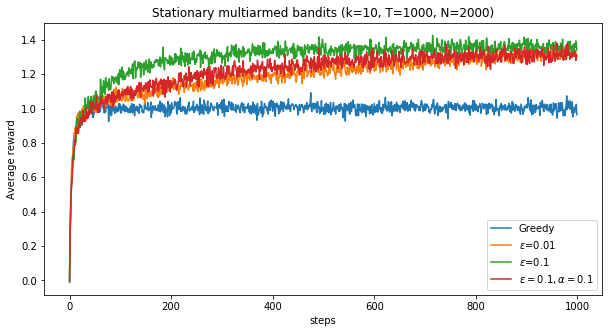

In [9]:
# Average reward
plt.figure(figsize=(10,5))
plt.title('Stationary multiarmed bandits (k=10, T={}, N={})'.format(T,N))
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.plot(greedy_r.mean(axis=0))
plt.plot(esmall_r.mean(axis=0))
plt.plot(elarge_r.mean(axis=0))
plt.plot(fstep_r.mean(axis=0))
plt.legend(['Greedy', '$\epsilon$=0.01', '$\epsilon$=0.1', r'$\epsilon=0.1, \alpha=0.1$']);

#### 3.1.2. Optimal action choice

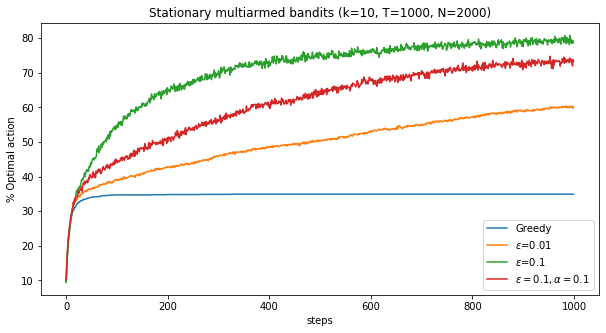

In [10]:
# Average reward
plt.figure(figsize=(10,5))
plt.title('Stationary multiarmed bandits (k=10, T={}, N={})'.format(T,N))
plt.xlabel('steps')
plt.ylabel('% Optimal action')
plt.plot(greedy_opt.mean(axis=0)*100)
plt.plot(esmall_opt.mean(axis=0)*100)
plt.plot(elarge_opt.mean(axis=0)*100)
plt.plot(fstep_opt.mean(axis=0)*100)
plt.legend(['Greedy', '$\epsilon$=0.01', '$\epsilon$=0.1', r'$\epsilon=0.1, \alpha=0.1$']);

### 3.2. Nonstationary testbed

In [11]:
# Testbed parameters
k = 10
T = 10000
N = 2000

# Bandit methods
fs1 = BanditFixedStepsize(k, epsilon=0.1, alpha=0.01)
fs2 = BanditFixedStepsize(k, epsilon=0.1, alpha=0.1)
fs3 = BanditFixedStepsize(k, epsilon=0.1, alpha=0.5)


# Run simulations
fs1_r, fs1_opt = run_nonstationary_testbed(k,N,T,fs1)
fs2_r, fs2_opt = run_nonstationary_testbed(k,N,T,fs2)
fs3_r, fs3_opt = run_nonstationary_testbed(k,N,T,fs3)

#### 3.2.1. Average reward

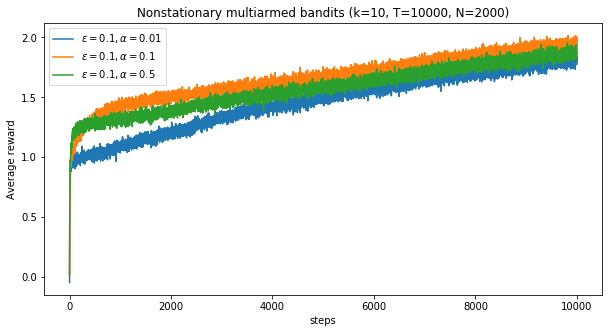

In [12]:
# Average reward
plt.figure(figsize=(10,5))
plt.title('Nonstationary multiarmed bandits (k=10, T={}, N={})'.format(T,N))
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.plot(fs1_r.mean(axis=0))
plt.plot(fs2_r.mean(axis=0))
plt.plot(fs3_r.mean(axis=0))
plt.legend([r'$\epsilon=0.1, \alpha=0.01$',r'$\epsilon=0.1, \alpha=0.1$',r'$\epsilon=0.1, \alpha=0.5$']);

#### 3.2.2. Optimal action choice

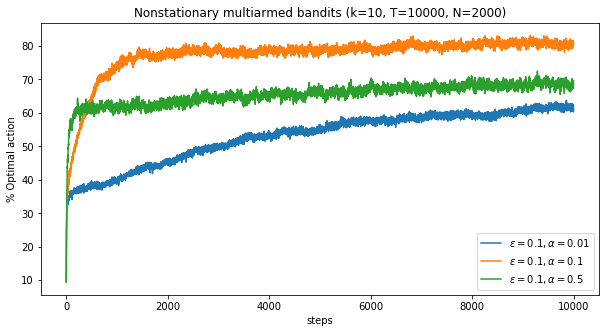

In [13]:
# Average reward
plt.figure(figsize=(10,5))
plt.title('Nonstationary multiarmed bandits (k=10, T={}, N={})'.format(T,N))
plt.xlabel('steps')
plt.ylabel('% Optimal action')
plt.plot(fs1_opt.mean(axis=0)*100)
plt.plot(fs2_opt.mean(axis=0)*100)
plt.plot(fs3_opt.mean(axis=0)*100)
plt.legend([r'$\epsilon=0.1, \alpha=0.01$',r'$\epsilon=0.1, \alpha=0.1$',r'$\epsilon=0.1, \alpha=0.5$']);